In [161]:
# Libs
import numpy as np
import matplotlib.pyplot as plt

## Synthetic World with assymetry for treasures

In [162]:
# world parameters
length, width = 500, 3
jump_length = 2

# probabilities of treasures, pirates, obstacles in percent:
rate_treasures, rate_pirates, rate_obstacles = .05, .05, .05

# create grid 
grid = np.zeros((length, width+2*jump_length))
for i in range(jump_length):
    grid[:,i] = grid[:,width+jump_length+i] = -1

# generate treasures, pirates and obstacles using MC sampling.
# the 0 the row is the most likely to have treasures, then the 1 then the 2
mc_samplings = [np.random.rand(length, width), np.random.rand(length, width), np.random.rand(length, width)]
rates = [rate_treasures, rate_pirates, rate_obstacles]
for i in range(length):
    for j in range(width):
        mc_sampls = [0.25*(j+1)*mc_samplings[0][i,j], mc_samplings[1][i,j], mc_samplings[2][i,j]]
        id = np.argmin(mc_sampls)
        if mc_sampls[id] <= rates[id]:
            if id == 0:
                grid[i, j+jump_length] = 1 # treasures
            elif id == 1:
                grid[i, j+jump_length] = 2 # pirates
            elif id == 2:
                grid[i, j+jump_length] = -1

In [163]:
data_treasures, data_pirates, data_obstacles = [], [], []
for i in range(length):
    for j in range(width):
        v = grid[:, jump_length:-jump_length][i, j] # grid[i, j]
        if v != 0:
            if v == 1:
                data_treasures.append((i, j))
            elif v == 2:
                data_pirates.append((i, j))
            elif v == -1:
                data_obstacles.append((i, j))

### Plot Synthetic World

Text(0,0.5,'probability  of treasures decreasing with height')

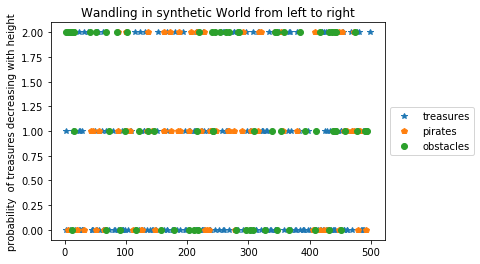

In [164]:
plt.plot(list(map(lambda x: x[0], data_treasures)), list(map(lambda x: x[1], data_treasures)), '*', label='treasures')
plt.plot(list(map(lambda x: x[0], data_pirates)), list(map(lambda x: x[1], data_pirates)), 'p', label='pirates')
plt.plot(list(map(lambda x: x[0], data_obstacles)), list(map(lambda x: x[1], data_obstacles)), 'o', label='obstacles')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Wandling in synthetic World from left to right')
plt.ylabel('probability  of treasures decreasing with height')

### Q Learning

In [165]:
def action_value_function(states, grid, reward_treasure=10, cost_pirates=-10):
    """   """
    score = 0.
    for i, j in states:
        if grid[i,j] == 2:
            score += cost_pirates
        elif grid[i,j] == 1:
            score += reward_treasure
    return score / len(states)

def next_possible_state(coord, grid, w=2):
    """
        returns next possible states or -1 if end of grid
        one can not move across obstacles.
    """
    i, j = coord
    i = i+1
    if i > grid.shape[0]:
        return -1
    else:
        next_states = list(map(lambda x: (i, x), 
                               list(filter(lambda x: (width > x > -1) and (grid[i, x] != -1),
                                           range(j-w, j+w))) ))
        if len(next_states) != 0:
            return next_states
        else:
            print('WARNING: No Path Possible to the right!')
            print('WARNING: contiguous ostacles recreate World')
            return 'No Path Possible to the right!'

def depth_2_exploration(state, grid, jump_length=2):
    """
        get possible paths, the ones not going through obstacles
        returns:
            [pos_0, pos_1, [possible pos_2]]
        or at the end of grid:
            [pos_0, pos_1] 
    """
    return [[state, c, next_possible_state(c, grid, jump_length)]
            for c in next_possible_state(state, grid)]

def q_update(states_depth_2, grid, Q_states_policies, alpha=0.05):
    """
        from path and possible paths, reconstitutes the variable needed to update Q:
            Q(s_t,a_t) <- (1-alpha)*Q(s_t,a_t) + alpha*(r+max_a Q(s_t+1,a))
    """
    i_0, j_0 = states_depth_2[0]
    i_1, j_1 = states_depth_2[1]
    action = j_1 - j_0
    q = Q_states_policies[i_0, j_0, action]
    r = action_value_function([(i_1, j_1)], grid)
    
    if states_depth_2[2] == -1:
        qs_max = 0.
    else:
        qs = []
        for c in states_depth_2[2]:
            if type(c) == tuple:
                qs.append(-10)
            else:
                print(c)
                i, j = c
                action = j - j_1
                qs.append(Q_states_policies[i_1, j_1, action])
        qs_max = max(qs)
    
    Q_states_policies[i_0, j_0, action] = (1 - alpha) * q + alpha * (r + qs_max)


In [166]:


class Policy:
    """ simple policy that simply choses the best policy from the Q table """
    def __init__(self, Q_states_policies):
        self.path = []
        self.Q_states_policies = Q_states_policies
        
    def action(self, state, alpha=0.25, jump_length=jump_length):
        possible_coords = depth_2_exploration(state,
                                              grid[:, jump_length:-jump_length],
                                              jump_length)
        i, j = state
        qs = []
        for c in possible_coords:
            #print(c[1])
            ii, jj = c[1]
            action = jj - j
            qs.append(self.Q_states_policies[i, j, action])
        
        qs = np.array(qs)
        if np.where(qs==max(qs))[0].shape[0] > 1:
            id = np.random.choice(list(range(qs.shape[0])))
        else:
            id = np.argmax(qs)

        next_states = possible_coords[id]
        self.path.append(next_states[1])
        # q learning
        q_update(next_states, grid[:, jump_length:-jump_length], self.Q_states_policies, alpha)
        
        self.reward = action_value_function(self.path, grid[:, jump_length:-jump_length])
        return self.path[-1]


### Run Policies/Q-Learning: N.B. Sometimes the synthetic world needs to be re-generated

In [167]:
"""
    Run policies with Q learning
"""

init_q = action_value_function([(i,0) for i in range(length)] +
                               [(i,1) for i in range(length)] +
                               [(i,2) for i in range(length)],
                               grid[:, jump_length:-jump_length])

d_results = {}
for alpha in [.05, .1, .2, .3, .4, .5]: # alpha = learning rate
    # Q : S X A -> R
    #  we have 2xjump_length+1 possible actions as possible jumps to the right
    Q_states_policies = np.ones((length, width, 2*jump_length+1)) * init_q
    rewards = []
    for j in range(50):
        policy = Policy(Q_states_policies)
        move = policy.action((-1, 1), )

        for i in range(length-2):
            move = policy.action(move)
        rewards.append(policy.reward)
    d_results[alpha] = rewards

### Q Learning results: algo has improved after few iterations

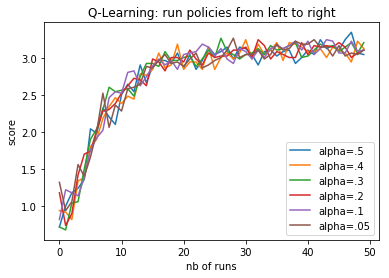

In [168]:
plt.plot(d_results[.5], label='alpha=.5')
plt.plot(d_results[.4], label='alpha=.4')
plt.plot(d_results[.3], label='alpha=.3')
plt.plot(d_results[.2], label='alpha=.2')
plt.plot(d_results[.1], label='alpha=.1')
plt.plot(d_results[.05], label='alpha=.05')

plt.legend(loc='lower right')
plt.title('Q-Learning: run policies from left to right')
plt.ylabel('score')
plt.xlabel('nb of runs');